In [11]:
from bankingSystem import * 
from helperFunctions import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import warnings 
import multiprocessing
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%pylab inline 
pylab.rcParams['figure.figsize'] = (16, 8)
pylab.rcParams['font.size'] = 25

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [12]:
import numpy as np
import pandas as pd
label = ["baseModel", "highReserve", "highLeverage","lowBorrow", "noBorrow","lowCorrelation", "noCorrelation","301", "302",]

defaultCollection = np.concatenate([np.load("defaultSimulation1/defaultCollection_" + l + ".npy") for l in label],axis=0)
defaultBanks = np.concatenate([np.load("defaultSimulation1/defaultBanks_" + l + ".npy") for l in label],axis=0)

FileNotFoundError: [Errno 2] No such file or directory: 'defaultSimulation1/defaultCollection_302.npy'

In [ ]:
pd.DataFrame(columns=label, data = defaultCollection.T).describe()

,baseModel,highReserve,highLeverage,lowBorrow,noBorrow,lowCorrelation,noCorrelation,301,302
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000
mean,12.034000,9.290500,14.587500,7.018500,3.546500,11.790500,11.73150,1.678000,0.079000
std,20.013348,16.897156,22.561424,16.642916,13.551113,15.408222,3.19758,7.979859,1.513904
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,9.00000,0.000000,0.000000
50%,2.000000,1.000000,3.000000,0.000000,0.000000,5.000000,12.00000,0.000000,0.000000
75%,14.000000,10.000000,20.000000,4.000000,0.000000,16.000000,14.00000,0.000000,0.000000
max,100.000000,90.000000,100.000000,97.000000,100.000000,88.000000,22.00000,99.000000,55.000000


In [ ]:
pylab.rcParams['figure.figsize'] = (20, 5)
def plotDefaultBanks(defaultBanks, cats, labels):
    fig, axs = plt.subplots(1, 2)
    # Defining custom 'xlim' and 'ylim' values.
    custom_xlim = (-5, 105)
    custom_ylim = (0, 500)
    # Setting the values for all axes.
    plt.setp(axs, xlim=custom_xlim, ylim=custom_ylim)
    fig.suptitle('Number of Defaults over 100 Banks(From the laregest to the smallest)')
    axs[0].bar(range(100), defaultBanks[0].sum(axis=0), label = "Base Model",alpha=0.5)
    axs[0].bar(range(100), defaultBanks[cats[0]].sum(axis=0), label = labels[0],alpha=0.5)
    axs[0].set_xlabel("Bank ID")
    axs[0].set_ylabel("Number of Defaults")
    axs[0].legend()
    axs[1].bar(range(100), defaultBanks[0].sum(axis=0), label = "Base Model",alpha=0.5)
    axs[1].bar(range(100), defaultBanks[cats[1]].sum(axis=0), label = labels[1],alpha=0.5)
    axs[1].set_xlabel("Bank ID")
    axs[1].set_ylabel("Number of Defaults")
    axs[1].legend()

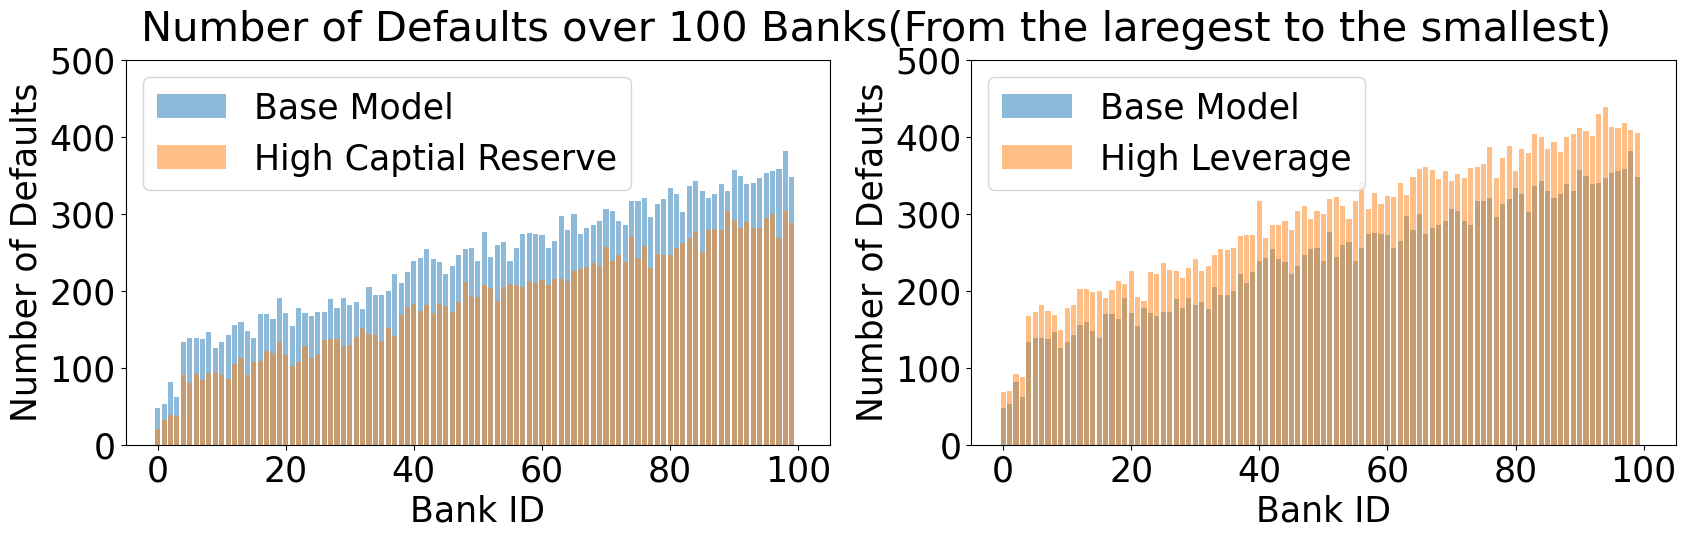

In [ ]:
plotDefaultBanks(defaultBanks, [1,2], ["High Captial Reserve", "High Leverage"])

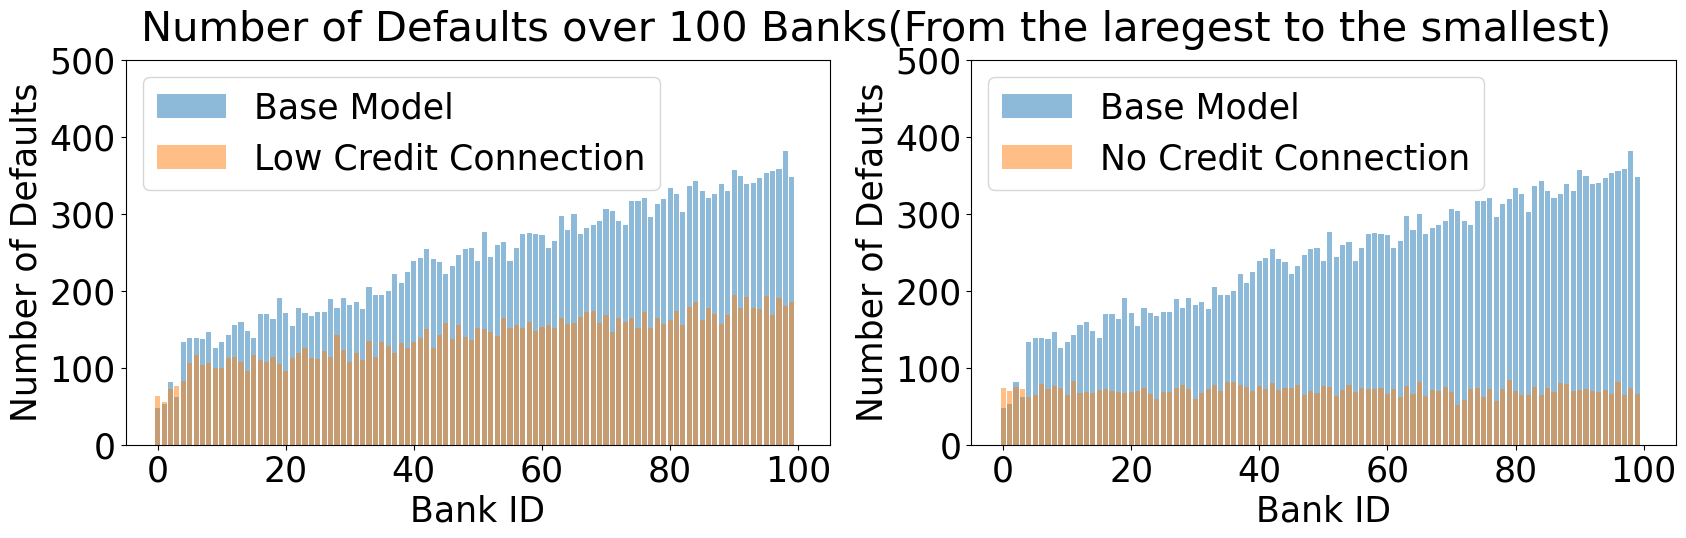

In [ ]:
plotDefaultBanks(defaultBanks, [3,4], ["Low Credit Connection", "No Credit Connection"])

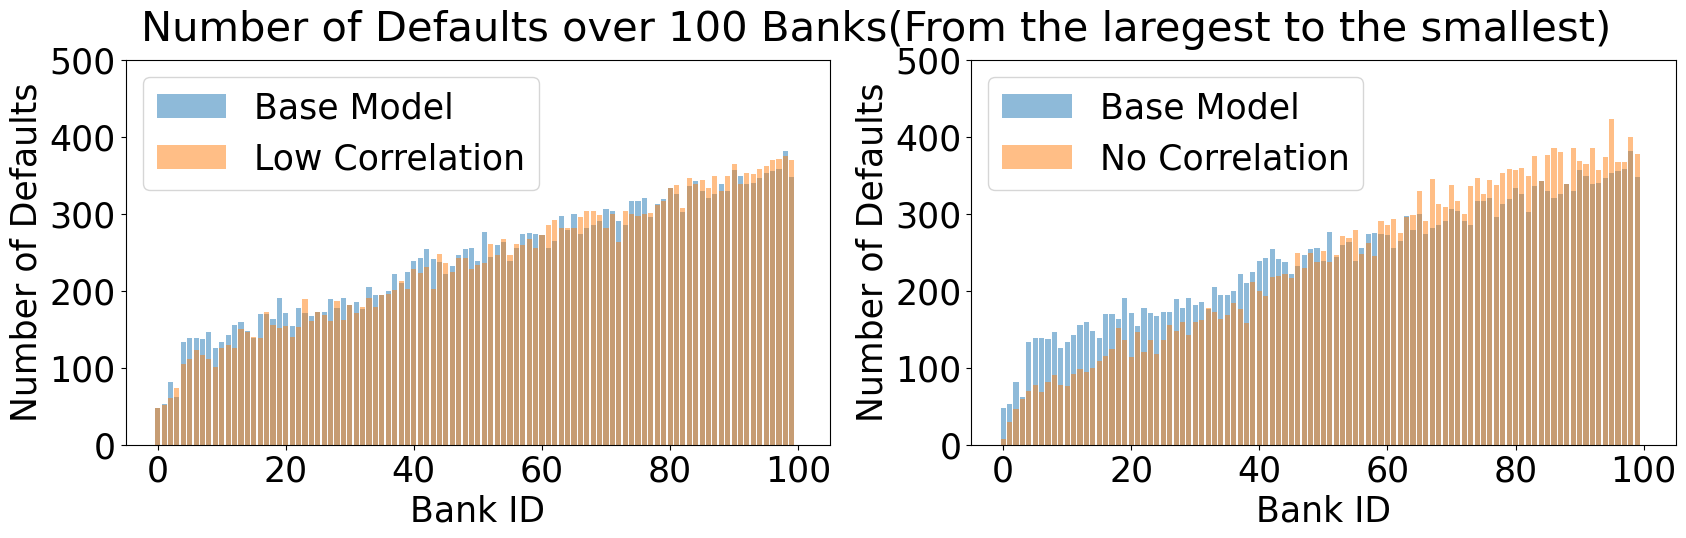

In [ ]:
plotDefaultBanks(defaultBanks, [5,6], ["Low Correlation", "No Correlation"])

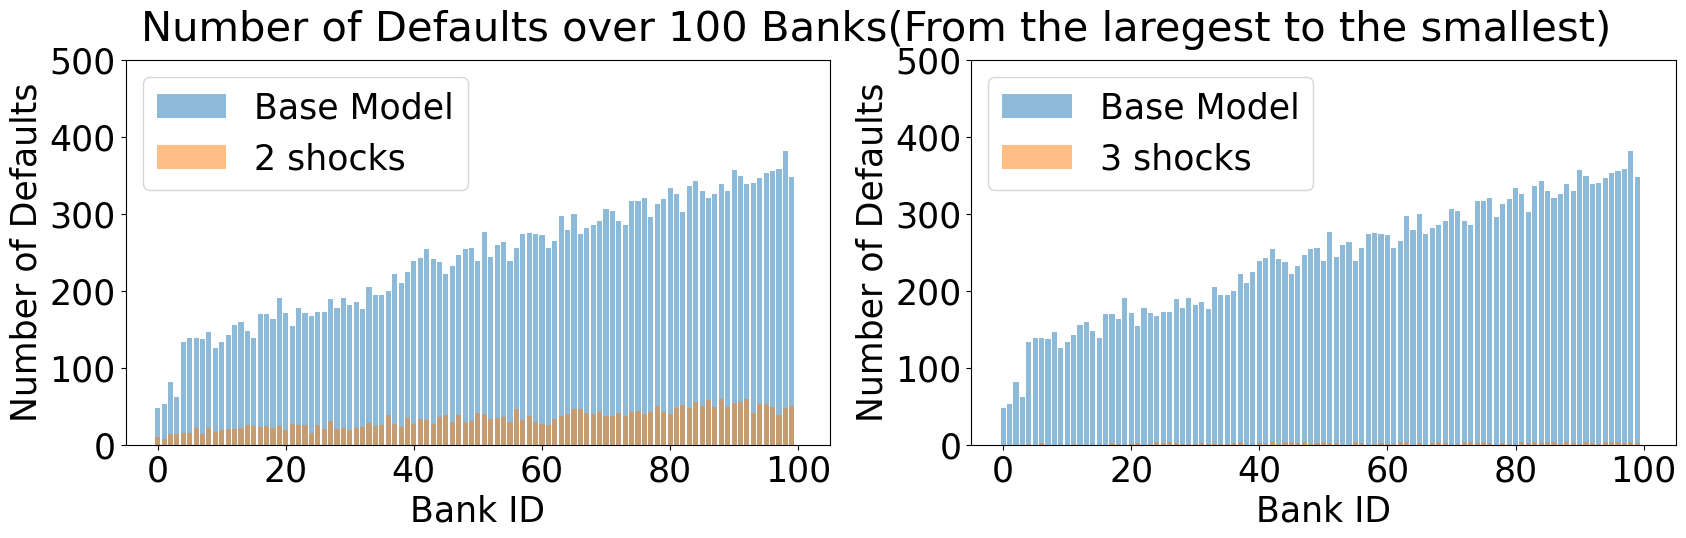

In [ ]:
plotDefaultBanks(defaultBanks, [7,8], ["2 shocks", "3 shocks"])

In [ ]:
# portfolio return volatility
def R(cor,shockSize):
    returnVolatiliy = 0.18/np.sqrt(252)
    # return correlation matrix
    cMatrix = np.ones((100,100))*cor
    np.fill_diagonal(cMatrix, 1)
    Cholesky = np.linalg.cholesky(cMatrix * returnVolatiliy**2)
    r = np.abs(shockSize * Cholesky @ np.random.randn(100,1))
    return r

Rs = np.array([R(0.8,5).flatten() for _ in range(2000)])
Rs.shape


(2000, 100)

In [ ]:
for cor in [0.9, 0.7,0]:
    Rs = np.array([R(cor,10).flatten() for _ in range(2000)])
    print(np.corrcoef(Rs.T).mean(), np.corrcoef(Rs.T).std(), Rs.mean(axis = 0).mean(), Rs.mean(axis=0).std())

0.7700513500942062 0.02430077046238323 0.09058714077262431 0.0007306316256328302
0.4532732457532835 0.05747235253839384 0.0897749498523735 0.0010496801455202097
0.01042698949296754 0.10191339954260457 0.09055277908432281 0.001557724269397034
